In [ ]:
%pip install seaborn --upgrade
%

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\basil\.pyenv\pyenv-win\versions\3.9.12\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
# import ptitprince as pt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
import pingouin as pg
import statsmodels.api as sm
# import language_tool_python as ltp
import sys
sys.path.append('..')  
# from src.visualization.plot import raincloud, raincloud2, RainCloud
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

#remove warnings
import warnings
warnings.filterwarnings('ignore')

    

In [5]:
df = pd.read_csv('../data/processed/restored_dv2_dv3_dv2h_cleaned.csv')

# just print some descriptive info
for engine in df.engine.unique():
    print('Experiment=', end=' ')
    print(engine)
    print('-'*15)
    print('Size=', end=' ')
    print(df[df.engine==engine].shape)
    # print n subject
    print('N datasets =', end=' ')
    # group by engine and prolific_id, then count unique dataset_id
    dd = df[df.engine==engine].groupby(['prolific_id']).dataset_id.unique()
    n = sorted([i[0] for i in dd.values])
    print(len(n))
    print('N participants =', end=' ')
    print(df[df.engine==engine].dataset_id.nunique())

    # check if n unique dataset_id == n unique prolific_id
    if len(n) != df[df.engine==engine].dataset_id.nunique():
        print('WARNING: n unique dataset_id != n unique prolific_id')
        # show which dataset_id is doubled
        print('Doubled dataset_id=', end=' ')
        print([i for i in n if n.count(i) > 1])

    print('N trials = ', end='')
    # print n trials per subject
    print(df[df.engine==engine].prolific_id.value_counts().unique()[0])
    print()

df.loc[(((df.a0=='yes') & (df.agree1==1)) | ((df.a0=='no') & (df.agree1==0))), 'endorse'] = 1
df.loc[(((df.a0=='yes') & (df.agree1==0)) | ((df.a0=='no') & (df.agree1==1))), 'endorse'] = 0
df['endorse'] = df.endorse.astype(int)

Experiment= dv2
---------------
Size= (3542, 29)
N datasets = 77
N participants = 77
N trials = 46

Experiment= dv3
---------------
Size= (3420, 29)
N datasets = 76
N participants = 76
N trials = 45

Experiment= dv2_humanized
---------------
Size= (3542, 29)
N datasets = 77
N participants = 77
N trials = 46



In [6]:
avg_source = df.groupby(['engine', 'prolific_id', 'cond', 'source'], as_index=False).mean(numeric_only=True)
avg_answer = df.groupby(['engine', 'prolific_id', 'cond', 'answer'], as_index=False).mean(numeric_only=True)

count = 0
nan = 0
avg = None
bias = []

for id in avg_source.prolific_id.unique():
    for cond in avg_source.cond.unique():
        # get engine using id
        engine = avg_source[avg_source.prolific_id==id].engine.values[0]
        count += 1
        del avg
        avg = avg_source

     
        bias_source = avg[(avg.source=='Human') & (avg.prolific_id==id) & (avg.cond==cond)].agree.values[0]\
        - avg[(avg.source=='AI') & (avg.prolific_id==id) & (avg.cond==cond)].agree.values[0]
        # assert that there is only one value for each condition
        assert len(avg[(avg.source=='Human') & (avg.prolific_id==id) & (avg.cond==cond)].agree) == 1
        assert len(avg[(avg.source=='AI') & (avg.prolific_id==id) & (avg.cond==cond)].agree) == 1
 
     
        try: 
            del avg
            avg = avg_answer
            bias_answer = \
                avg[(avg.answer=='Human') & (avg.prolific_id==id) & (avg.cond==cond)].agree.values[0]\
                - avg[(avg.answer=='AI') & (avg.prolific_id==id) & (avg.cond==cond)].agree.values[0]
        except:
            nan += 1
            bias_answer = None 
        
        bias.append(
            {
                'engine': engine,
                'prolific_id': id,
                'cond': cond,
                'bias_source': bias_source,
                'bias_answer': bias_answer
            }
        )

bias = pd.DataFrame(bias)



In [9]:
bias2 = []
avg_source = df.groupby(['engine', 'prolific_id',  'source'], as_index=False).mean(numeric_only=True)
avg_answer = df.groupby(['engine', 'prolific_id',  'answer'], as_index=False).mean(numeric_only=True)
count = 0
for id in avg_source.prolific_id.unique():
        # get engine using id
    engine = avg_source[avg_source.prolific_id==id].engine.values[0]
    count += 1
    del avg
    avg = avg_source
    bias_source = avg[(avg.source=='Human') & (avg.prolific_id==id)].agree.values[0]\
        - avg[(avg.source=='AI') & (avg.prolific_id==id)].agree.values[0]
    # assert that there is only one value for each condition
    assert len(avg[(avg.source=='Human') & (avg.prolific_id==id)].agree) == 1
    assert len(avg[(avg.source=='AI') & (avg.prolific_id==id)].agree) == 1
    try: 
        del avg
        avg = avg_answer
        bias_answer = \
            avg[(avg.answer=='Human') & (avg.prolific_id==id)].agree.values[0]\
            - avg[(avg.answer=='AI') & (avg.prolific_id==id)].agree.values[0]
    except:
        nan += 1
        bias_answer = None 
    
    bias2.append(
        {
            'engine': engine,
            'prolific_id': id,
            'bias_source': bias_source,
            'bias_answer': bias_answer
        }
    )

bias2 = pd.DataFrame(bias2)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [7]:
def raincloud(x, y, markersize, df, order, width=1.1, bw=0.25, palette='Set2'):
    # f, ax = plt.subplots(figsize=(5*2.5, 5*2.5))

    means = df.groupby(x)[y].mean().reindex(order)
    sns.scatterplot(x=means.index, y=means, color='white', edgecolor='black', s=150/2, linewidth=1.5, zorder=4, clip_on=False)


    ax = pt.half_violinplot(x=x, y=y, data=df, bw=bw, cut=0., linewidth=0, alpha=1,  dodge=True,
                            scale="area", width=width, inner=None, orient='v', zorder=1, palette=palette, order=order)

    ax = sns.stripplot(x=x, y=y, data=df,edgecolor="white",  linewidth=1, order=order,
                       size=markersize, orient='v', zorder=2, jitter=1, alpha=0.6, palette=palette, dodge=True, clip_on=False)


    ax2 = sns.pointplot(x=x, y=y, data=df, color='black',  join=False, errorbar='se', linewidth=1, edgecolor='black', capsize=.1, zorder=3, bw=0, order=order, dodge=True)
    return ax

,Source,SS,DF,MS,F,p-unc,np2
0,engine,0.711022,2,0.355511,27.57356,1.905248e-11,0.195455
1,Within,2.926754,227,0.012893,NaN,NaN,NaN


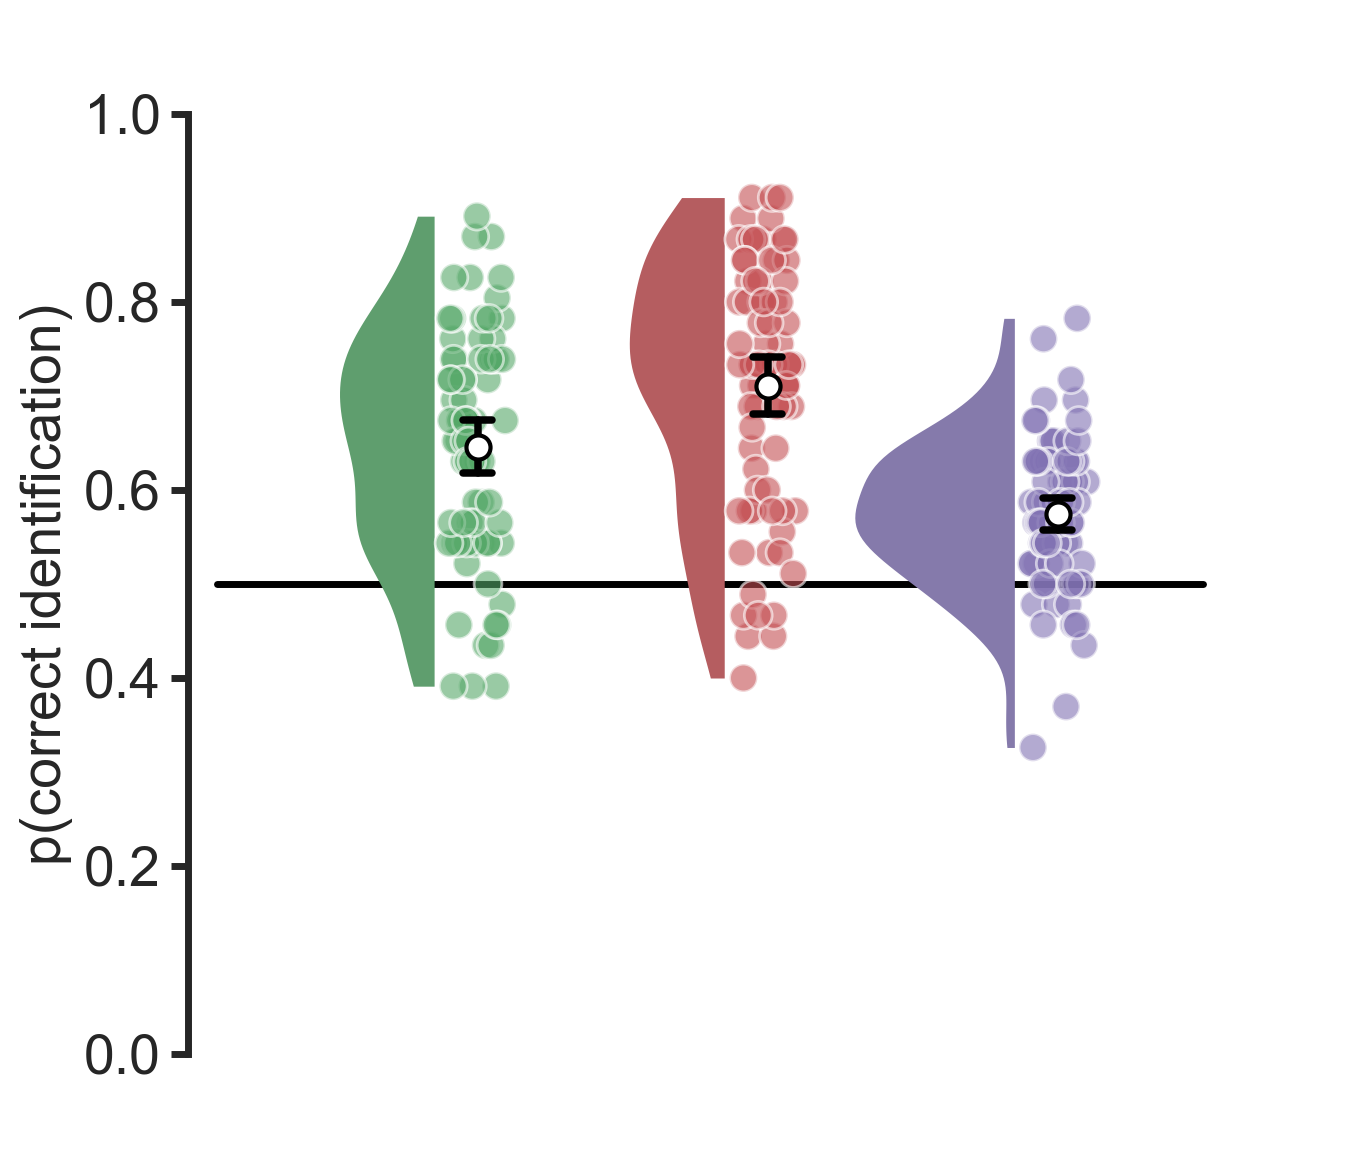

In [6]:
sns.set(
    rc={'figure.figsize':(7,6), "figure.dpi": 200, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# get deep palette
palette = sns.color_palette('deep')
sns.set_palette(palette[2:])
# get new palette
palette = sns.color_palette()
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# change axes width
plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


order = ['dv2', 'dv3', 'dv2_humanized']
# -------------------------------------------------------------------------------
# Plot 1: Turing Test 
# -------------------------------------------------------------------------------
avg = df.groupby(['engine','prolific_id'], as_index=False).mean(numeric_only=True)
plt.plot([-.9, 2.5], [0.5, 0.5], color='black',  zorder=-5, linewidth=2.5)
raincloud(x='engine', y='correct', markersize=10, df=avg, order=order, bw=.4, palette=palette)
plt.ylim(-.1, 1.1)
# plt.xticks(range(2), ('AI', 'Human'))
plt.xticks(range(3), ('', '', ''))
plt.xlabel('')
plt.ylabel('p(correct identification)')
plt.xlim(-1, 3)
# plt.title('Agreement (yes/no)')
# remove ticks length x axis

sns.despine(trim=True, bottom=True);
plt.tick_params(axis='x', which='both', length=0)

plt.tight_layout()
# plt.suptitle(engine, fontsize=30, y=1.3)
# plt.savefig('../outputs/figures/fig3_1.svg', dpi=300, bbox_inches='tight')

pg.anova(data=avg, dv='correct', between='engine', detailed=True)

In [7]:
pg.anova(data=avg, dv='correct', between='engine', effsize='np2')

,Source,ddof1,ddof2,F,p-unc,np2
0,engine,2,227,27.57356,1.905248e-11,0.195455


,Source,SS,DF,MS,F,p-unc,np2
0,engine,0.711022,2,0.355511,27.57356,1.905248e-11,0.195455
1,Within,2.926754,227,0.012893,NaN,NaN,NaN


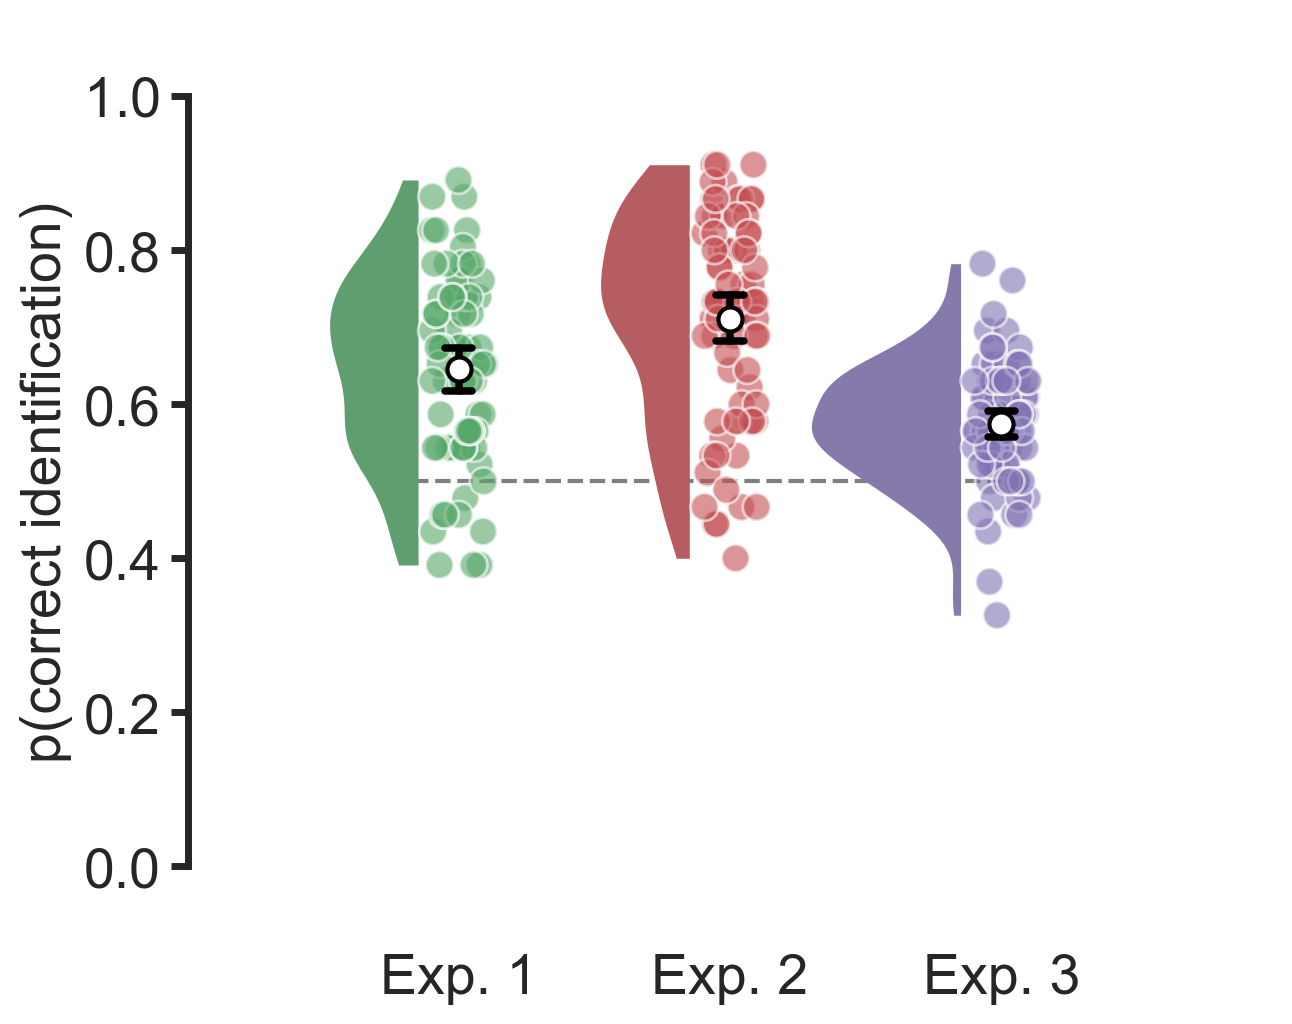

In [8]:
sns.set(
    rc={'figure.figsize':(7,6), "figure.dpi": 200, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# get deep palette
palette = sns.color_palette('deep')
sns.set_palette(palette[2:])
# get new palette
palette = sns.color_palette()
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# change axes width
plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


order = ['dv2', 'dv3', 'dv2_humanized']
y = 'correct'
# -------------------------------------------------------------------------------
# Plot 1: Turing Test 
# -------------------------------------------------------------------------------
avg = df.groupby(['engine','prolific_id'], as_index=False).mean(numeric_only=True)
plt.plot([-0.25, 2], [0.5, 0.5], '--', color='black', alpha=0.5, zorder=-5)
raincloud(x='engine', y=y, markersize=10, df=avg, order=order, bw=.4, palette=palette)
plt.ylim(-.1, 1.1)
# plt.xticks(range(2), ('AI', 'Human'))
plt.xticks(range(3), ('Exp. 1', 'Exp. 2', 'Exp. 3'))
plt.xlabel('')
plt.ylabel('p(correct identification)')
plt.xlim(-1, 3)
# plt.title('Agreement (yes/no)')
# remove ticks length x axis

sns.despine(trim=True, bottom=True);
plt.tick_params(axis='x', which='both', length=0)

# plt.tight_layout()
# plt.suptitle(engine, fontsize=30, y=1.3)
# plt.savefig('figs/fig3_1.svg', dpi=300, bbox_inches='tight')

pg.anova(data=avg, dv=y, between='engine', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,engine,0.199492,2,0.099746,2.528932,0.082029,0.022178
1,Within,8.795564,223,0.039442,NaN,NaN,NaN


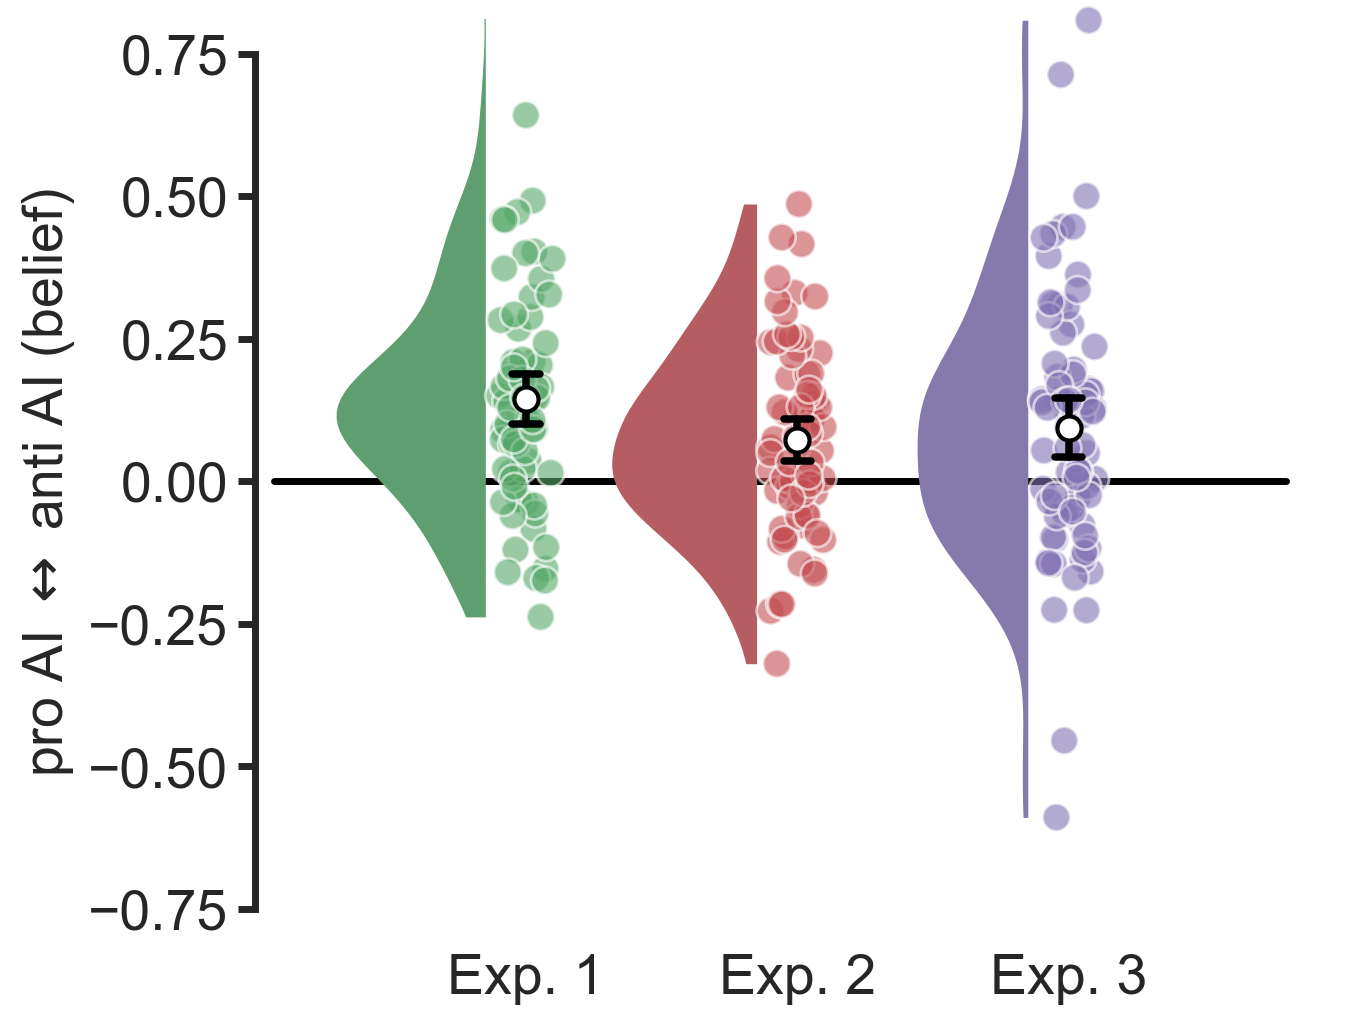

In [9]:
sns.set(
    rc={'figure.figsize':(7,6), "figure.dpi": 200, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# get deep palette
palette = sns.color_palette('deep')
sns.set_palette(palette[2:])
# get new palette
palette = sns.color_palette()
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# change axes width
plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


order = ['dv2', 'dv3', 'dv2_humanized']
y = 'bias_answer'
# -------------------------------------------------------------------------------
# Plot 1: Bias belief 
# -------------------------------------------------------------------------------
avg = bias2.groupby(['engine','prolific_id'], as_index=False).mean(numeric_only=True)
plt.plot([-.93, 2.8], [0, 0], color='black',  zorder=-5, linewidth=2.5)
raincloud(x='engine', y=y, markersize=10, df=avg, order=order, bw=.4, palette=palette)
plt.ylim(-.81, .81)
# plt.xticks(range(2), ('AI', 'Human'))
plt.xticks(range(3), ('Exp. 1', 'Exp. 2', 'Exp. 3'))
plt.xlabel('')


plt.ylabel(f'pro AI $\leftrightarrow$ anti AI (belief)')
plt.xlim(-1, 3)
# plt.title('Agreement (yes/no)')
# remove ticks length x axis

sns.despine(trim=True, bottom=True);
plt.tick_params(axis='x', which='both', length=0)

# plt.tight_layout()
# plt.suptitle(engine, fontsize=30, y=1.3)
# plt.savefig('figs/fig3_1.svg', dpi=300, bbox_inches='tight')

pg.anova(data=bias2, dv=y, between='engine', detailed=True)

# pairwise comparisons
# pg.pairwise_ttests(data=bias2, dv=y, between='engine', padjust='bonf')


,Source,SS,DF,MS,F,p-unc,np2
0,engine,0.082788,2,0.041394,2.555256,0.079905,0.022018
1,Within,3.677282,227,0.016199,NaN,NaN,NaN


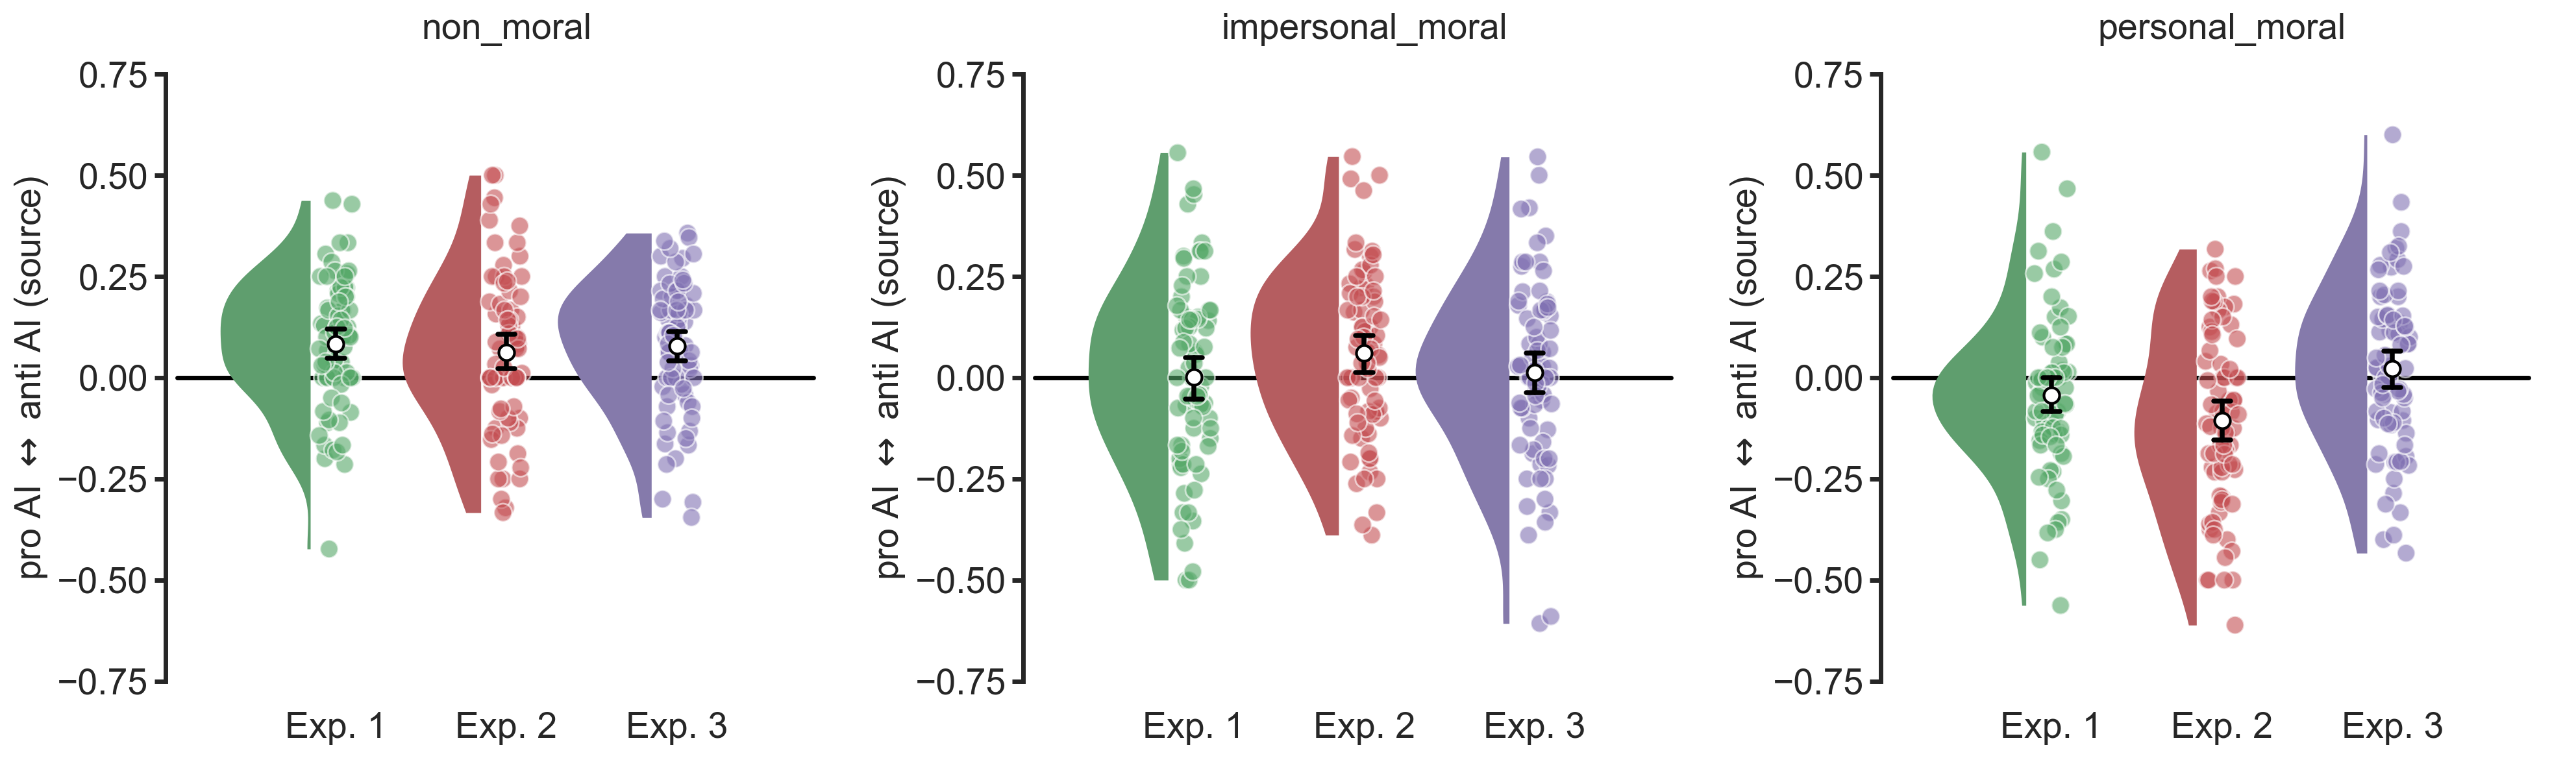

In [66]:
sns.set(
    rc={'figure.figsize':(20,6), "figure.dpi": 200, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# get deep palette
palette = sns.color_palette('deep')
sns.set_palette(palette[2:])
# get new palette
palette = sns.color_palette()
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# change axes width
plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


order = ['dv2', 'dv3', 'dv2_humanized']
y = 'bias_source'
# -------------------------------------------------------------------------------
# Plot 1: Bias belief 
# -------------------------------------------------------------------------------
avg = bias.groupby(['cond', 'engine', 'prolific_id'], as_index=False).mean(numeric_only=True)
count = 0
for cond in ['non_moral', 'impersonal_moral', 'personal_moral']:
    count += 1
    plt.subplot(1, 3, count)
    plt.plot([-.93, 2.8], [0, 0], color='black',  zorder=-5, linewidth=2.5)
    raincloud(x='engine', y=y, markersize=10, df=avg[avg.cond==cond], order=order, bw=.4, palette=palette)
    plt.ylim(-.81, .81)
    # plt.xticks(range(2), ('AI', 'Human'))
    plt.xticks(range(3), ('Exp. 1', 'Exp. 2', 'Exp. 3'))
    plt.xlabel('')


    plt.ylabel(f'pro AI $\leftrightarrow$ anti AI (source)')
    plt.xlim(-1, 3)
    # plt.title('Agreement (yes/no)')
    # remove ticks length x axis

    sns.despine(trim=True, bottom=True);
    plt.tick_params(axis='x', which='both', length=0)
    plt.title(cond)

plt.tight_layout()
# plt.suptitle(engine, fontsize=30, y=1.3)
# plt.savefig('figs/fig3_1.svg', dpi=300, bbox_inches='tight')

pg.anova(data=bias2, dv=y, between='engine', detailed=True)

# pairwise comparisons
# pg.pairwise_ttests(data=bias2, dv=y, between='engine', padjust='bonf')


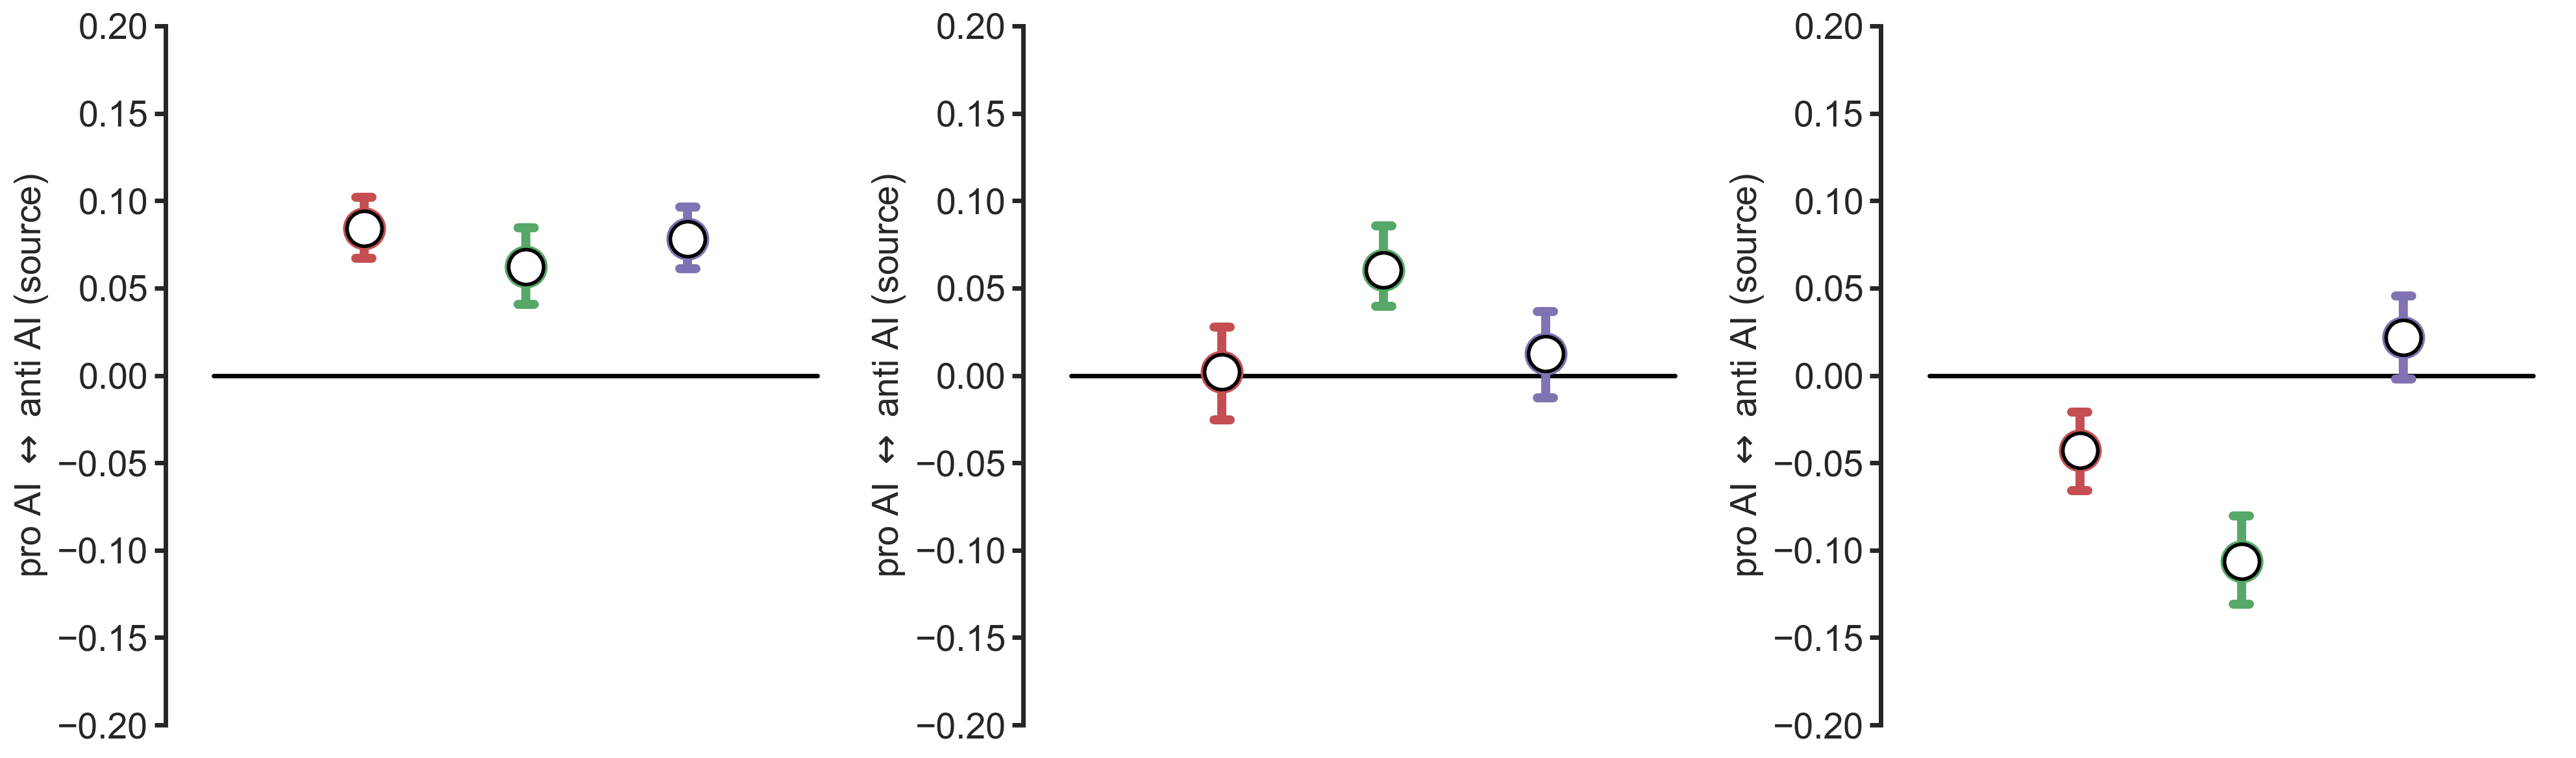

In [6]:
sns.set(
    rc={'figure.figsize':(20,6), "figure.dpi": 200, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# get deep palette
palette = sns.color_palette('deep')
sns.set_palette((palette[3], palette[2], palette[4]))
# get new palette
palette = sns.color_palette()
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# change axes width
plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


order = ['dv2', 'dv3', 'dv2_humanized']
y = 'bias_source'
# -------------------------------------------------------------------------------
# Plot 1: Bias belief 
# -------------------------------------------------------------------------------
avg = bias.groupby(['cond', 'engine', 'prolific_id'], as_index=False).mean(numeric_only=True)
count = 0
for cond in ['non_moral', 'impersonal_moral', 'personal_moral']:
    count += 1
    plt.subplot(1, 3, count)
    plt.plot([-.93, 2.8], [0, 0], color='black',  zorder=-5, linewidth=2.5)

    sns.pointplot(x='engine', y=y, data=avg[avg.cond==cond],  zorder=-1, ci=68, order=order, capsize=0.1, errwidth=5, palette=palette, scale=3.2, join=False)
    plt.scatter(x=[0, 1, 2], y=avg[avg.cond==cond].groupby('engine').bias_source.mean().reindex(order), color='white', s=150*2.5, edgecolor='black', linewidth=2, zorder=4)

# sns.barplot(x='cond', y=y, data=avg_,  zorder=-1, ci=68, order=order, errwidth=4, palette=palette)
    plt.ylim(-.2, 0.2)

# remove xticks

    sns.despine(bottom=True, offset=10)

    # plt.ylim(-.81, .81)
    # plt.xticks(range(2), ('AI', 'Human'))
    # plt.xticks(range(3), ('Exp. 1', 'Exp. 2', 'Exp. 3'))
    plt.xlabel('')
    plt.xticks([])


    plt.ylabel(f'pro AI $\leftrightarrow$ anti AI (source)')
    # plt.xlim(-1, 3)
    # plt.title('Agreement (yes/no)')
    # remove ticks length x axis

    sns.despine(trim=True, bottom=True);
    plt.tick_params(axis='x', which='both', length=0)
    # if cond == 'non_moral':
    #     plt.title('Non-moral')
    # elif cond == 'impersonal_moral':
    #     plt.title('Impersonal moral')
    # else:
    #     plt.title('Personal moral')

plt.tight_layout()
# plt.suptitle(engine, fontsize=30, y=1.3)
# plt.savefig('figs/fig3_1.svg', dpi=300, bbox_inches='tight')

# pg.anova(data=bias2, dv=y, between='engine', detailed=True)

# pairwise comparisons
# pg.pairwise_ttests(data=bias2, dv=y, between='engine', padjust='bonf')
plt.savefig('../outputs/figures/fig4_B.svg', dpi=300)
plt.show()


In [11]:
# rename cond in scenario and engine in experiment
# bias.rename(columns={'cond': 'scenario', 'engine': 'experiment'}, inplace=True)

# pg.pairwise_tests(data=bias, dv='bias_answer', between='experiment', within='scenario', padjust='bonf', subject='prolific_id').round(6)
pg.ttest(bias[(bias.engine=='dv2_humanized') & (bias.cond=='personal_moral')].bias_answer, bias[(bias.engine=='dv2') & (bias.cond=='personal_moral')].bias_answer)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.978095,148.430483,two-sided,0.049769,"[-0.18, -0.0]",0.322062,1.045,0.502441


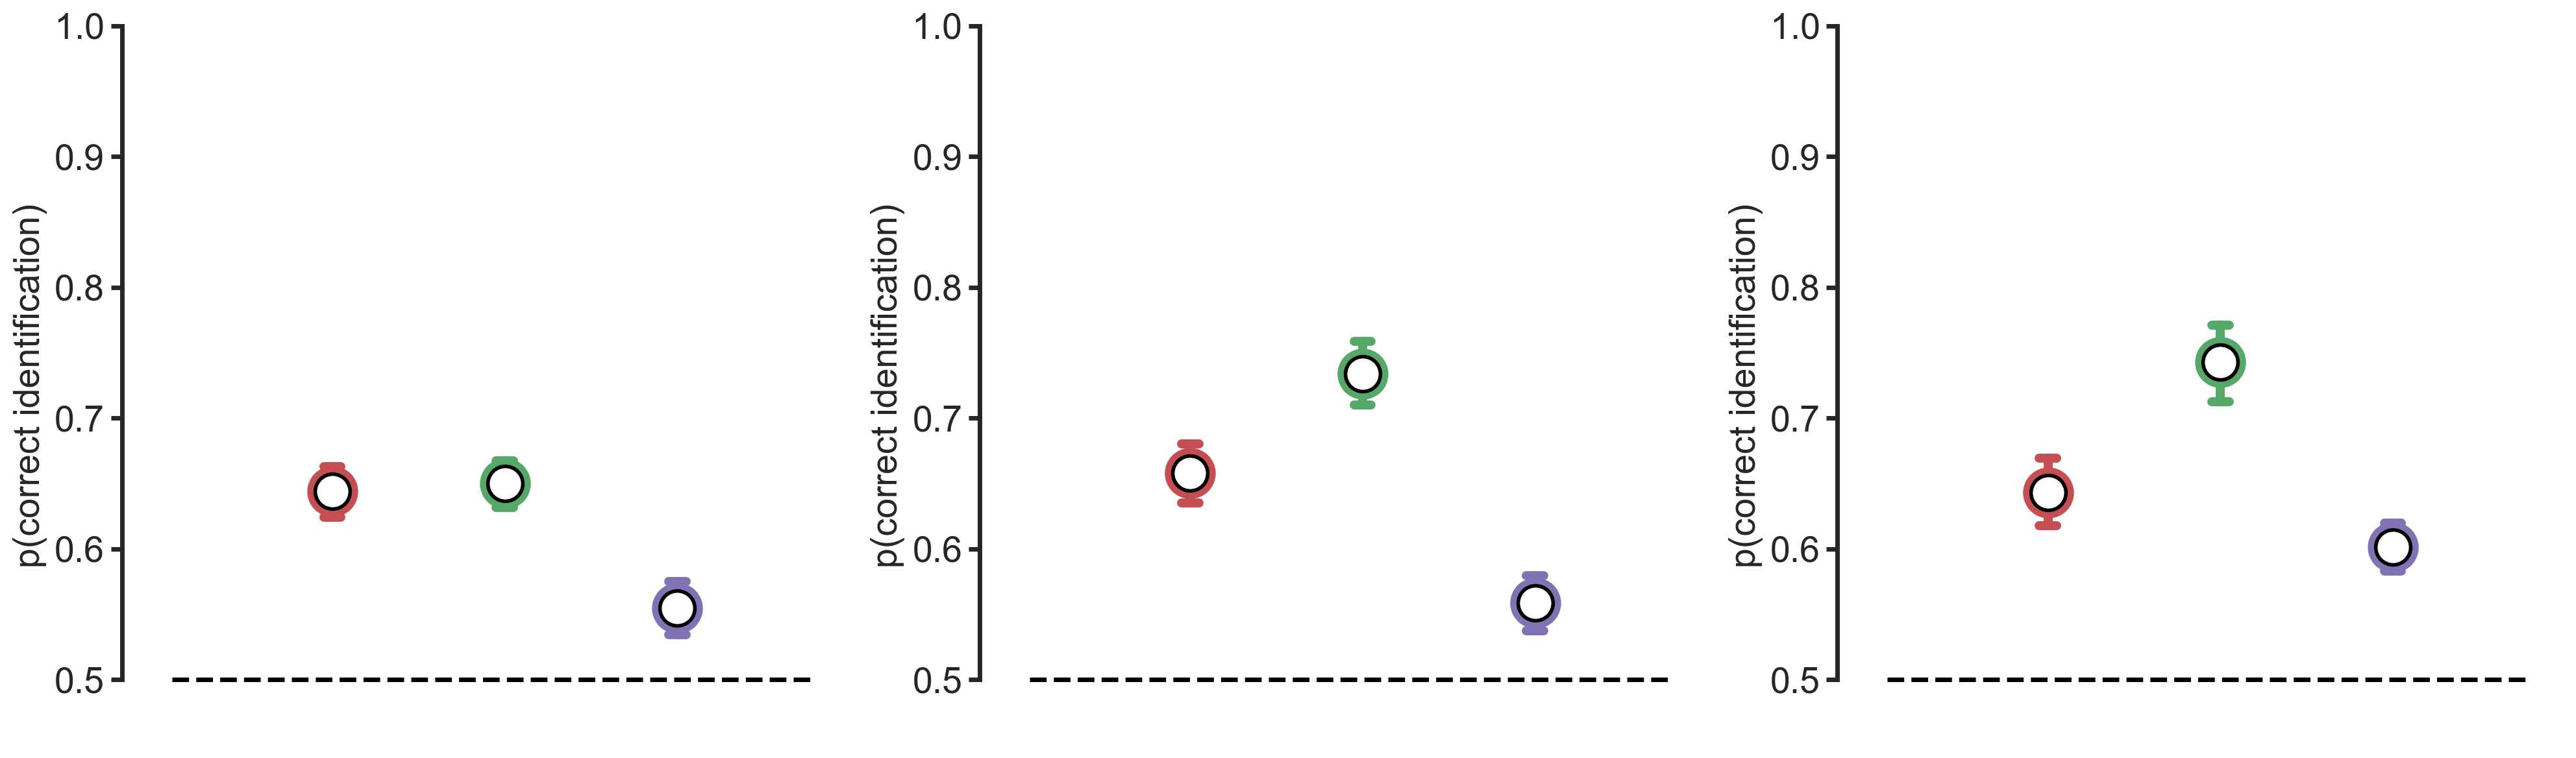

In [6]:
sns.set(
    rc={'figure.figsize':(20,6), "figure.dpi": 200, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# get deep palette
palette = sns.color_palette('deep')
sns.set_palette((palette[3], palette[2], palette[4]))
# get new palette
palette = sns.color_palette()
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# change axes width
plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


order = ['dv2', 'dv3', 'dv2_humanized']
y = 'correct'
# -------------------------------------------------------------------------------
# Plot 1: Bias belief 
# -------------------------------------------------------------------------------
avg = df.groupby(['cond', 'engine', 'prolific_id'], as_index=False).mean(numeric_only=True)
count = 0
for cond in ['non_moral', 'impersonal_moral', 'personal_moral']:
    count += 1
    plt.subplot(1, 3, count)
    plt.plot([-.93, 2.8], [0.5, 0.5], color='black',  zorder=-5, linewidth=2.5, linestyle='--')

    sns.pointplot(x='engine', y=y, data=avg[avg.cond==cond],  zorder=-1, ci=80, order=order, capsize=0.1, errwidth=5, palette=palette, scale=3.8, join=False)
    plt.scatter(x=[0, 1, 2], y=avg[avg.cond==cond].groupby('engine').correct.mean().reindex(order), color='white', s=150*2.5, edgecolor='black', linewidth=2, zorder=4)

# sns.barplot(x='cond', y=y, data=avg_,  zorder=-1, ci=68, order=order, errwidth=4, palette=palette)
    plt.ylim(.45, 1)

# remove xtick

    sns.despine(bottom=True, offset=10)

    # plt.ylim(-.81, .81)
    # plt.xticks(range(2), ('AI', 'Human'))
    # plt.xticks(range(3), ('Exp. 1', 'Exp. 2', 'Exp. 3'))
    plt.xlabel('')
    plt.xticks([])


    plt.ylabel(f'p(correct identification)')
    # plt.xlim(-1, 3)
    # plt.title('Agreement (yes/no)')
    # remove ticks length x axis

    sns.despine(trim=True, bottom=True);
    plt.tick_params(axis='x', which='both', length=0)
    # if cond == 'non_moral':
    #     plt.title('Non-moral')
    # elif cond == 'impersonal_moral':
    #     plt.title('Impersonal moral')
    # else:
    #     plt.title('Personal moral')

plt.tight_layout()
# plt.suptitle(engine, fontsize=30, y=1.3)
# plt.savefig('figs/fig3_1.svg', dpi=300, bbox_inches='tight')

# pg.anova(data=bias2, dv=y, between='engine', detailed=True)

# pairwise comparisons
# pg.pairwise_ttests(data=bias2, dv=y, between='engine', padjust='bonf')
plt.savefig('../outputs/figures/fig4_A.svg', dpi=300)
plt.show()


In [19]:
pg.anova(data=avg[avg.cond=="personal_moral"], dv='correct', between='engine', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,engine,0.805519,2,0.40276,14.425395,0.000001,0.112764
1,Within,6.337880,227,0.02792,NaN,NaN,NaN


NameError: name 'bias2' is not defined

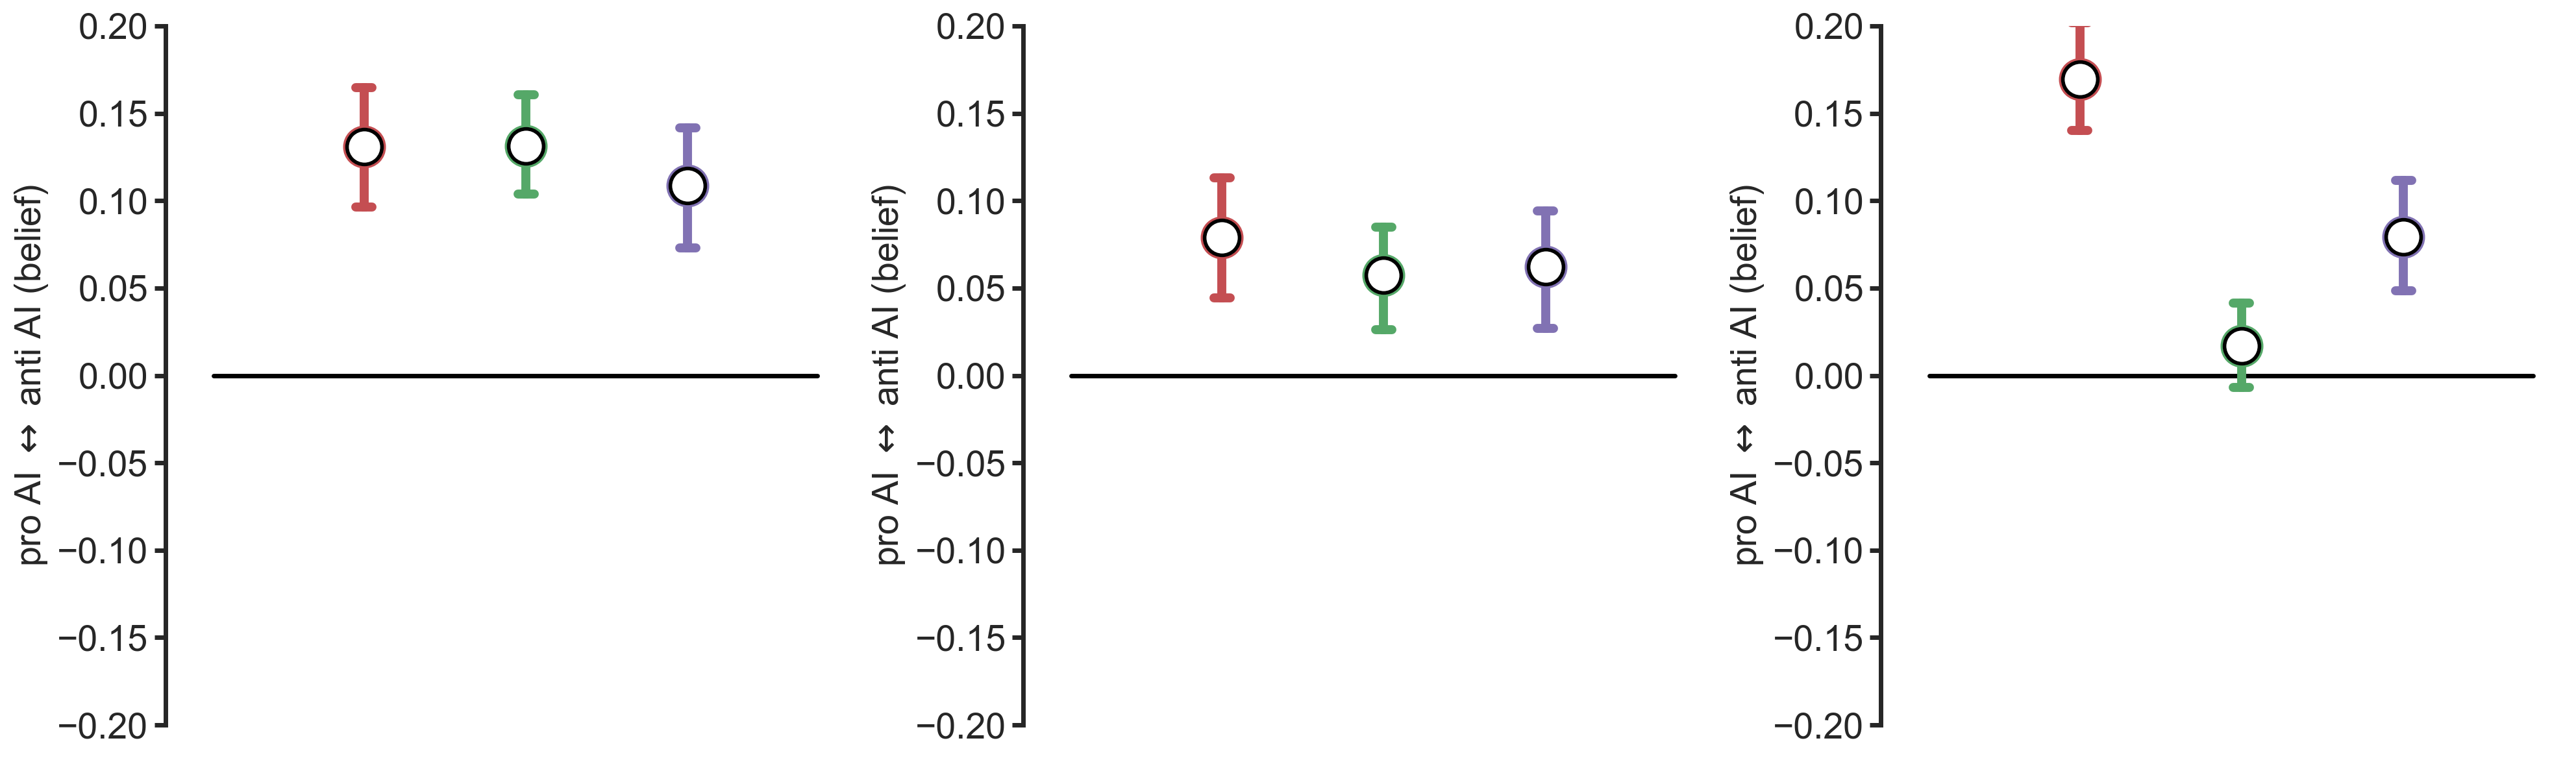

In [7]:
sns.set(
    rc={'figure.figsize':(20,6), "figure.dpi": 200, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# get deep palette
palette = sns.color_palette('deep')
sns.set_palette((palette[3], palette[2], palette[4]))
# get new palette
palette = sns.color_palette()
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# change axes width
plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


order = ['dv2', 'dv3', 'dv2_humanized']
y = 'bias_answer'
# -------------------------------------------------------------------------------
# Plot 1: Bias belief 
# -------------------------------------------------------------------------------
avg = bias.groupby(['cond', 'engine', 'prolific_id'], as_index=False).mean(numeric_only=True)
count = 0
for cond in ['non_moral', 'impersonal_moral', 'personal_moral']:
    count += 1
    plt.subplot(1, 3, count)
    plt.plot([-.93, 2.8], [0, 0], color='black',  zorder=-5, linewidth=2.5)

    sns.pointplot(x='engine', y=y, data=avg[avg.cond==cond],  zorder=-1, ci=68, order=order, capsize=0.1, errwidth=5, palette=palette, scale=3.2, join=False)
    plt.scatter(x=[0, 1, 2], y=avg[avg.cond==cond].groupby('engine').bias_answer.mean().reindex(order), color='white', s=150*2.5, edgecolor='black', linewidth=2, zorder=4)

# sns.barplot(x='cond', y=y, data=avg_,  zorder=-1, ci=68, order=order, errwidth=4, palette=palette)
    plt.ylim(-.2, 0.2)

# remove xticks

    sns.despine(bottom=True, offset=10)

    plt.xticks([])
    # plt.ylim(-.81, .81)
    # plt.xticks(range(2), ('AI', 'Human'))
    # plt.xticks(range(3), ('Exp. 1', 'Exp. 2', 'Exp. 3'))
    plt.xlabel('')


    plt.ylabel(f'pro AI $\leftrightarrow$ anti AI (belief)')
    # plt.xlim(-1, 3)
    # plt.title('Agreement (yes/no)')
    # remove ticks length x axis

    sns.despine(trim=True, bottom=True);
    plt.tick_params(axis='x', which='both', length=0)
    # plt.title(cond)

plt.tight_layout()
# plt.suptitle(engine, fontsize=30, y=1.3)
# plt.savefig('figs/fig3_1.svg', dpi=300, bbox_inches='tight')

pg.anova(data=bias2, dv=y, between='engine', detailed=True)

# pairwise comparisons
# pg.pairwise_ttests(data=bias2, dv=y, between='engine', padjust='bonf')
plt.savefig('../outputs/figures/fig4_C.svg', dpi=300, bbox_inches='tight')


In [9]:
pg.anova(data=bias[bias.cond=='personal_moral'], dv='bias_answer', between='engine', detailed=True)
# ttest against 0 for engine dv2_humanized
pg.ttest(bias[bias.cond=='personal_moral'][bias.engine=='dv3'].bias_answer, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.66115,72,two-sided,0.510626,"[-0.03, 0.07]",0.077382,0.159,0.100002


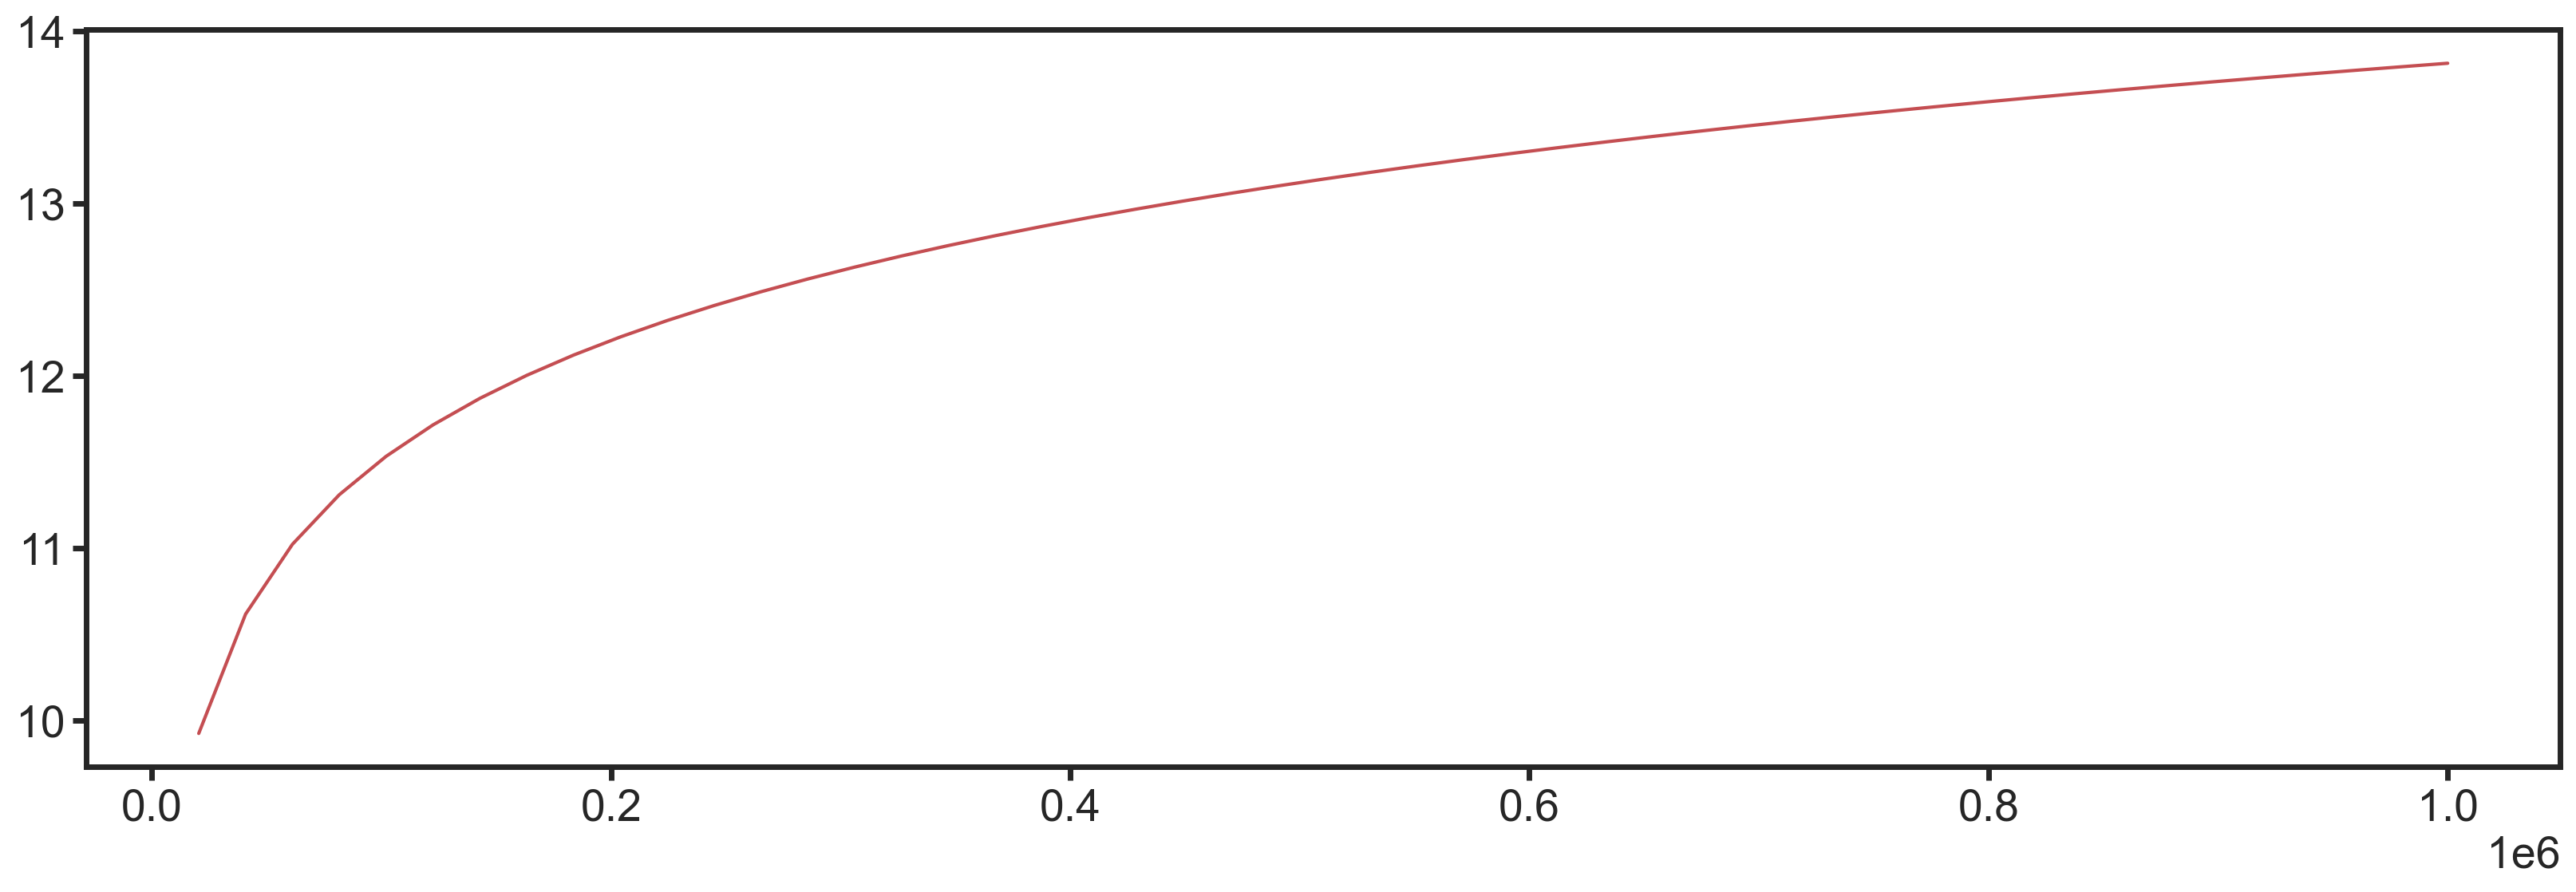

In [107]:
x = np.linspace(0, 1e6)

plt.plot(x, np.log(x))


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,engine,dv2,dv2_humanized,False,True,-1.617656,152.000000,two-sided,0.107810,0.323430,bonf,0.576,-0.259420
1,engine,dv2,dv3,False,True,0.680784,146.156680,two-sided,0.497085,1.000000,bonf,0.216,0.109653
2,engine,dv2_humanized,dv3,False,True,2.155000,144.257386,two-sided,0.032822,0.098465,bonf,1.449,0.347181


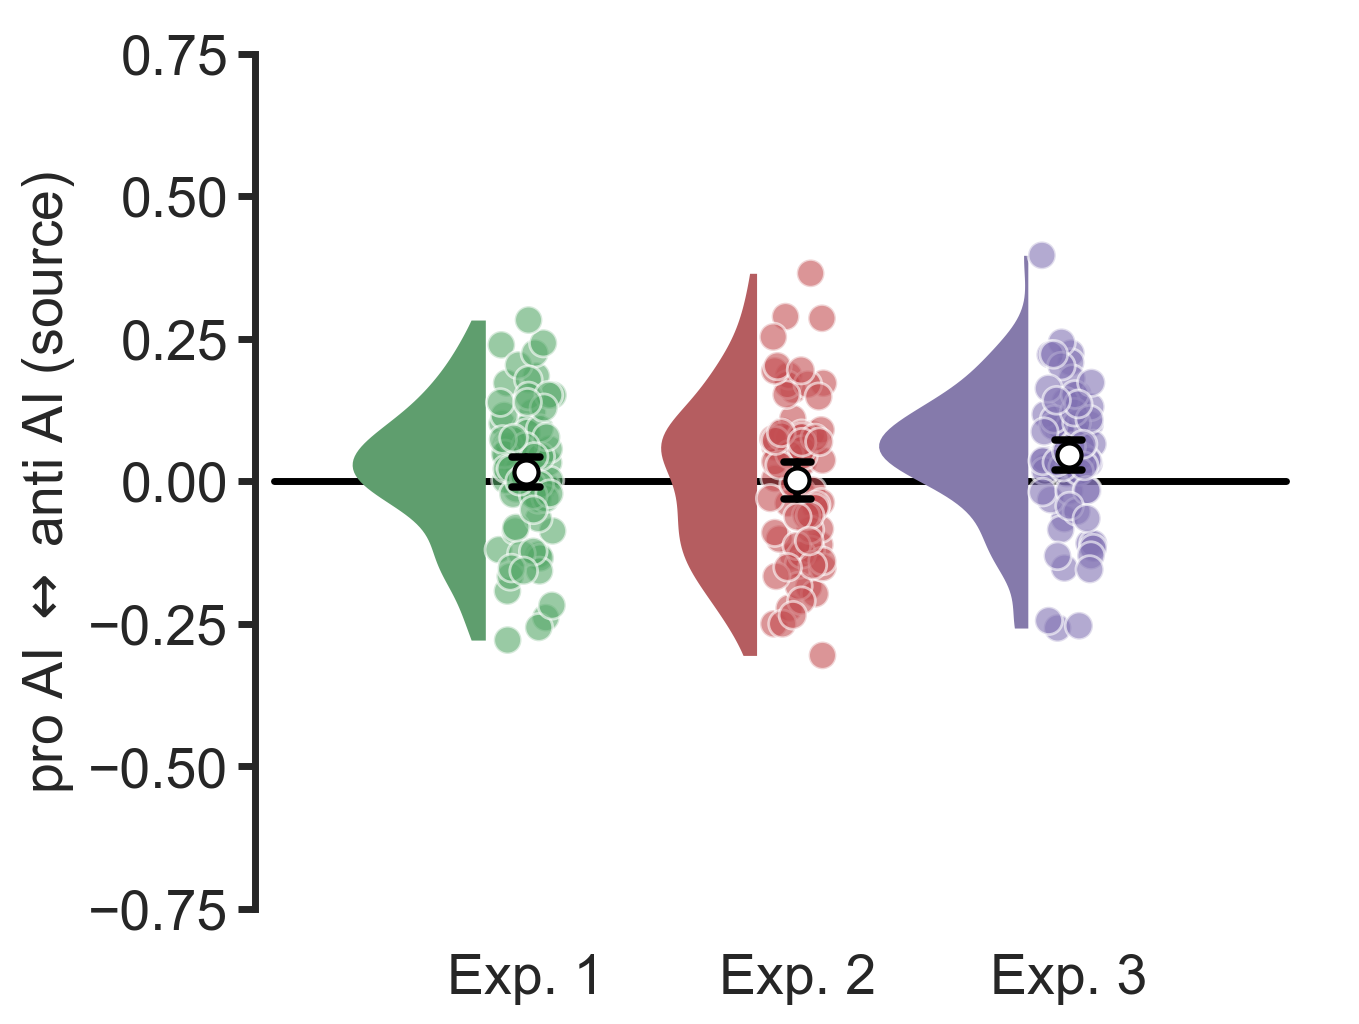

In [10]:
sns.set(
    rc={'figure.figsize':(7,6), "figure.dpi": 200, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# get deep palette
palette = sns.color_palette('deep')
sns.set_palette(palette[2:])
# get new palette
palette = sns.color_palette()
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# change axes width
plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


order = ['dv2', 'dv3', 'dv2_humanized']
y = 'bias_source'
# -------------------------------------------------------------------------------
# Plot 1: Turing Test 
# -------------------------------------------------------------------------------
avg = bias2.groupby(['engine','prolific_id'], as_index=False).mean(numeric_only=True)
plt.plot([-.93, 2.8], [0, 0], color='black',  zorder=-5, linewidth=2.5)
raincloud(x='engine', y=y, markersize=10, df=avg, order=order, bw=.4, palette=palette)
plt.ylim(-.81, .81)
# plt.xticks(range(2), ('AI', 'Human'))
plt.xticks(range(3), ('Exp. 1', 'Exp. 2', 'Exp. 3'))
plt.xlabel('')


plt.ylabel(f'pro AI $\leftrightarrow$ anti AI (source)')
plt.xlim(-1, 3)
# plt.title('Agreement (yes/no)')
# remove ticks length x axis

sns.despine(trim=True, bottom=True);
plt.tick_params(axis='x', which='both', length=0)

# plt.tight_layout()
# plt.suptitle(engine, fontsize=30, y=1.3)
# plt.savefig('figs/fig3_1.svg', dpi=300, bbox_inches='tight')

pg.anova(data=bias2, dv=y, between='engine', detailed=True)

# pairwise comparisons
pg.pairwise_ttests(data=bias2, dv=y, between='engine', padjust='bonf')


In [23]:
avg_answer

,engine,prolific_id,answer,dataset_id,id_first,item_idx,item_id,q_id,rt,correct,...,agree2,agree,choseLeft,errors,d_prime,len,source2,p_human,first_person,endorse
0,dv2,563f5535cbd4c60011dc9466,AI,36.0,0.333333,21.095238,1696.285714,2.0,45534.952381,0.619048,...,0.476190,0.452381,NaN,0.000000,1.186831,137.809524,0.380952,0.0,0.142857,0.238095
1,dv2,563f5535cbd4c60011dc9466,Human,36.0,0.600000,23.680000,1698.520000,2.0,78765.840000,0.480000,...,0.760000,0.720000,NaN,0.120000,1.186831,204.600000,0.480000,1.0,0.400000,0.360000
2,dv2,56bdf97bef423f000dcbb7eb,AI,14.0,0.681818,19.772727,679.227273,2.0,28921.136364,0.818182,...,0.545455,0.545455,NaN,0.090909,1.907474,287.454545,0.181818,0.0,0.181818,0.227273
3,dv2,56bdf97bef423f000dcbb7eb,Human,14.0,0.500000,25.000000,673.208333,2.0,39090.333333,0.666667,...,0.833333,0.833333,NaN,0.000000,1.907474,137.833333,0.666667,1.0,0.333333,0.375000
4,dv2,58a95ef0bb9e0f0001acaa8b,AI,25.0,0.500000,16.500000,1185.900000,2.0,61701.800000,0.750000,...,0.600000,0.600000,NaN,0.000000,0.965790,220.000000,0.250000,0.0,0.200000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,dv3,63ea44a0adefd2af8e13015c,Human,36.0,0.523810,22.333333,1712.238095,2.0,31513.142857,0.904762,...,0.904762,0.952381,NaN,0.190476,NaN,102.095238,0.904762,1.0,0.619048,0.523810
452,dv3,63ea61d8106e3e2dc14c4cc7,AI,9.0,0.500000,18.937500,436.312500,2.0,30568.812500,1.000000,...,0.875000,0.875000,NaN,0.000000,NaN,391.312500,0.000000,0.0,0.062500,0.312500
453,dv3,63ea61d8106e3e2dc14c4cc7,Human,9.0,0.413793,23.689655,444.000000,2.0,32190.068966,0.793103,...,0.827586,0.844828,NaN,0.172414,NaN,138.103448,0.793103,1.0,0.310345,0.448276
454,dv3,63ea627512244090788d46ec,AI,5.0,0.500000,19.777778,260.722222,2.0,35143.666667,0.944444,...,0.722222,0.638889,NaN,0.055556,NaN,408.944444,0.055556,0.0,0.000000,0.444444


,Contrast,cond,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,cond,-,impersonal_moral,non_moral,True,True,-2.840071,229.000000,two-sided,0.004916,0.014749,bonf,3.702,-0.253541
1,cond,-,impersonal_moral,personal_moral,True,True,3.573088,229.000000,two-sided,0.000430,0.001290,bonf,34.143,0.307611
2,cond,-,non_moral,personal_moral,True,True,6.688818,229.000000,two-sided,0.000000,0.000000,bonf,4.383e+07,0.605728
3,engine,-,dv2,dv2_humanized,False,True,-1.186818,152.000000,two-sided,0.237151,0.711453,bonf,0.332,-0.190328
4,engine,-,dv2,dv3,False,True,0.429879,144.823819,two-sided,0.667922,1.000000,bonf,0.19,0.069251
5,engine,-,dv2_humanized,dv3,False,True,1.488148,147.259972,two-sided,0.138850,0.416551,bonf,0.481,0.239658
6,cond * engine,impersonal_moral,dv2,dv2_humanized,False,True,-0.279845,152.000000,two-sided,0.779977,1.000000,bonf,0.18,-0.044878
7,cond * engine,impersonal_moral,dv2,dv3,False,True,-1.645892,149.140159,two-sided,0.101892,0.917026,bonf,0.602,-0.264589
8,cond * engine,impersonal_moral,dv2_humanized,dv3,False,True,-1.382147,150.129259,two-sided,0.168979,1.000000,bonf,0.418,-0.222242
9,cond * engine,non_moral,dv2,dv2_humanized,False,True,0.229111,152.000000,two-sided,0.819091,1.000000,bonf,0.178,0.036742


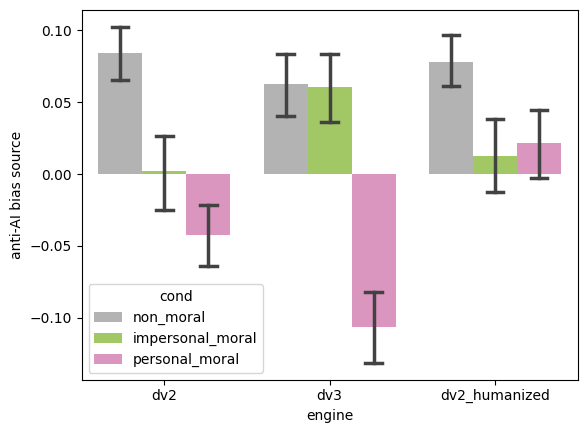

In [58]:
# agreement with AI
from statannotations.Annotator import Annotator

order = ['dv2', 'dv3', 'dv2_humanized']
hue_order = ['non_moral', 'impersonal_moral', 'personal_moral']
palette = sns.color_palette("Set2")
p = [palette[7], palette[4], palette[3]]
sns.set_palette(p)

ax = sns.barplot(x='engine', y='bias_source', hue='cond', data=bias, ci=68, capsize=.1, errwidth=2.5, hue_order=hue_order, order=order)
plt.ylabel('anti-AI bias source')

pg.pairwise_ttests(data=bias, dv='bias_source', between='engine', within='cond', padjust='bonf', within_first=True, subject='prolific_id').round(6)